# Sense Hat 1

In this documentation, we will go over loading the data, analyzing the data, building a fault early detection model, and machine state identification model using Gaussian Mixture Model.    

### Load data and analyze data


In [2]:
#install.packages(c("mclust", "anytime", "lubridate", "caret","imputeTS", "caret","mlbench"))


Installing packages into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [1]:
#load all the libraries
library(mclust)
#library(e1071)
#library(randomForest)
library(anytime) #used for formatting date
library(lubridate) #used for formatting date
library(imputeTS)
library(caret)
library(mlbench)
#library(qcc)
#library(dplyr)
#library(mdatools)
#library(parallelDist)

#set random seed value
set.seed(999)


Package 'mclust' version 5.4
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: lattice
Loading required package: ggplot2


In [2]:
#load data
#data = read.csv("C:/Users/Gupta/Google Drive/sensehat 1/senseHatOneFeatureData.csv", header=T)
id <- "1cVIus0A-m9_oPF_b9S_QCzAx6AkJsmkf"
data <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id))

data  = data[1000:nrow(data),]

tail(data)

,timeStamp,Temperature,Pressure,Humidity,mean,sd,median,trimmed,mad,min,⋯,sd.5,median.5,trimmed.5,mad.5,min.5,max.5,range.5,skew.5,kurtosis.5,se.5
24419,2019-01-14 21:42:19,24.95113,998.3945,20.49324,0.03641482,0.05882921,0.03763285,0.03617079,0.06119393,-0.1307444,⋯,1.817844,1.1307144,1.275809,0.8178161,0.03147348,14.21082,14.17935,3.611470,16.64678,0.06336605
24420,2019-01-14 21:43:19,24.81940,997.8640,20.37579,0.03793966,0.05985309,0.03593330,0.03756954,0.06328867,-0.1473890,⋯,1.921730,1.2888793,1.426763,0.9111604,0.01502718,20.57617,20.56114,4.174018,25.23322,0.06698731
24421,2019-01-14 21:44:20,24.78647,997.7788,20.17291,0.03760250,0.06793777,0.03569051,0.03653931,0.07127292,-0.1768186,⋯,2.800515,1.3899024,1.564742,1.0291702,0.07011591,25.23600,25.16589,4.384008,23.69407,0.09761980
24422,2019-01-14 21:45:19,24.68768,997.3386,19.75293,0.03629956,0.05815669,0.03569051,0.03535443,0.05795424,-0.1372575,⋯,2.869936,1.2157188,1.401306,0.8454578,0.04630647,43.41427,43.36796,6.589701,67.15148,0.10003969
24423,2019-01-14 21:46:19,24.53948,997.9087,19.85970,0.03739340,0.05215315,0.03860402,0.03760866,0.04787524,-0.1239901,⋯,2.603602,0.9754124,1.105718,0.6695225,0.03857730,35.28009,35.24152,6.460835,56.26034,0.09075587
24424,2019-01-14 21:47:19,24.45715,997.7788,20.62849,0.03699675,0.05170215,0.03811843,0.03824034,0.04895514,-0.1637924,⋯,2.573980,1.0432819,1.206066,0.6941752,0.01679074,25.72548,25.70868,4.909822,30.90428,0.08972330


In [3]:
str(data)

'data.frame':	23425 obs. of  70 variables:
 $ timeStamp  : Factor w/ 24403 levels "12/10/2018 0:00",..: 7850 7851 7852 7853 7854 7855 7856 7857 7858 7859 ...
 $ Temperature: num  24.6 24.6 24.6 24.5 24.4 ...
 $ Pressure   : num  1010 1009 1010 1010 1010 ...
 $ Humidity   : num  14.6 15.9 15.5 15.9 16.8 ...
 $ mean       : num  0.0332 0.0334 0.0334 0.0329 0.0351 ...
 $ sd         : num  0.0492 0.0574 0.0693 0.0534 0.0674 ...
 $ median     : num  0.0333 0.0328 0.0328 0.033 0.0352 ...
 $ trimmed    : num  0.033 0.0327 0.0332 0.033 0.0349 ...
 $ mad        : num  0.0529 0.0576 0.074 0.0532 0.0716 ...
 $ min        : num  -0.123 -0.139 -0.16 -0.158 -0.18 ...
 $ max        : num  0.185 0.23 0.227 0.208 0.279 ...
 $ range      : num  0.308 0.369 0.387 0.366 0.459 ...
 $ skew       : num  0.0588 0.0938 0.0274 -0.0276 0.0384 ...
 $ kurtosis   : num  -0.414 -0.294 -0.451 -0.135 -0.304 ...
 $ se         : num  0.00121 0.00141 0.00171 0.00132 0.00166 ...
 $ mean.1     : num  1.53 1.87 2.14 1.76 2.

#### Plot raw data

In [4]:
data$timeStamp = anytime(data$timeStamp)
#tail(data$timeStamp, 1000)

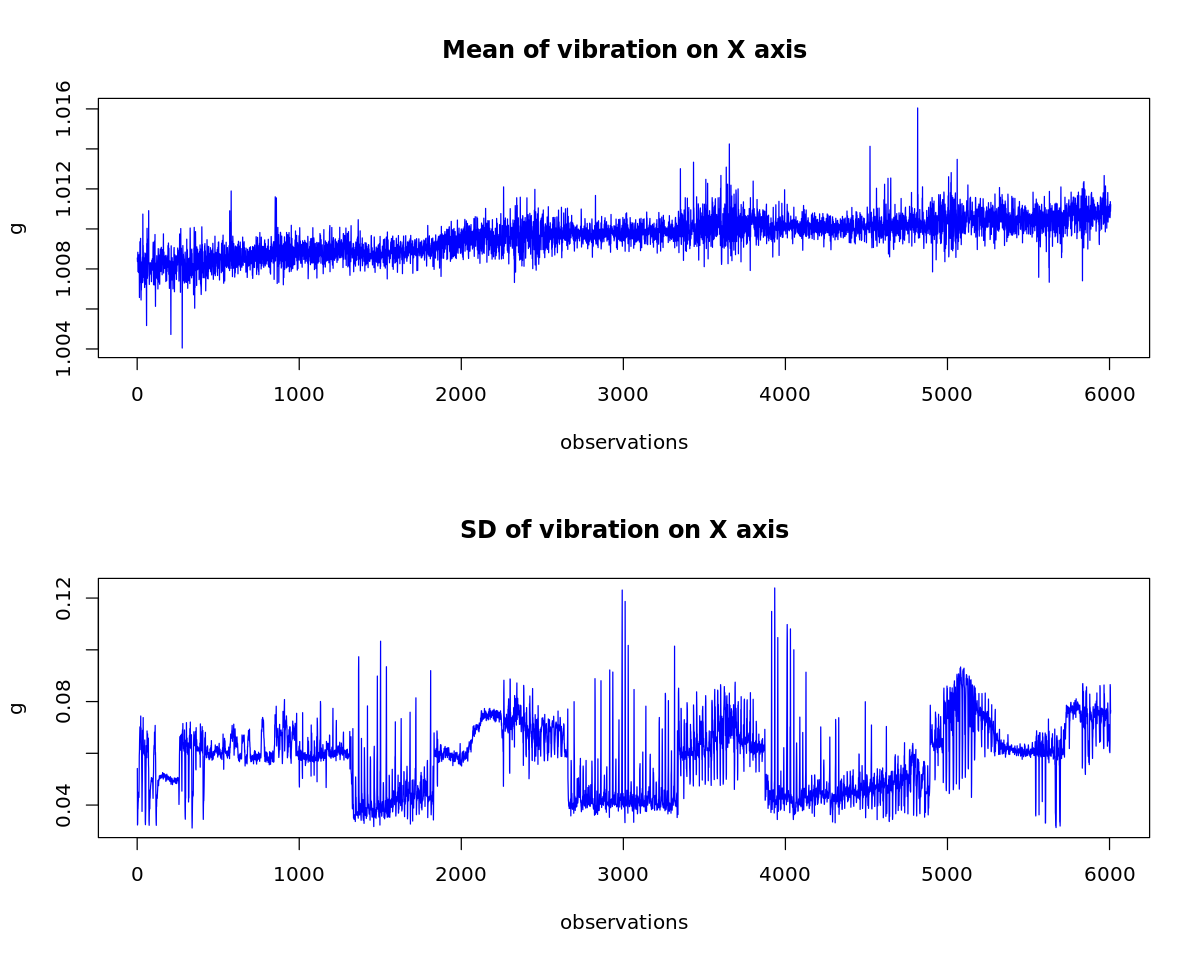

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)

data$timeStamp = anytime(data$timeStamp)
dat = subset.data.frame(data, timeStamp >= Sys.Date()-5)
par(mfrow=c(2,1))
plot(dat$mean.4, 
     type="l", 
     col="blue", 
     main="Mean of vibration on X axis",
     ylab="g",
     xlab="observations")
plot(dat$sd.4, 
     type="l", 
     col="blue", 
     main="SD of vibration on X axis",
     ylab="g",
     xlab="observations")

#### Summarize Data

Data need to be analyzed as the first step to see distributions in data, any outliers and uniqeness in the data. This step will give us the initial picture of the data.

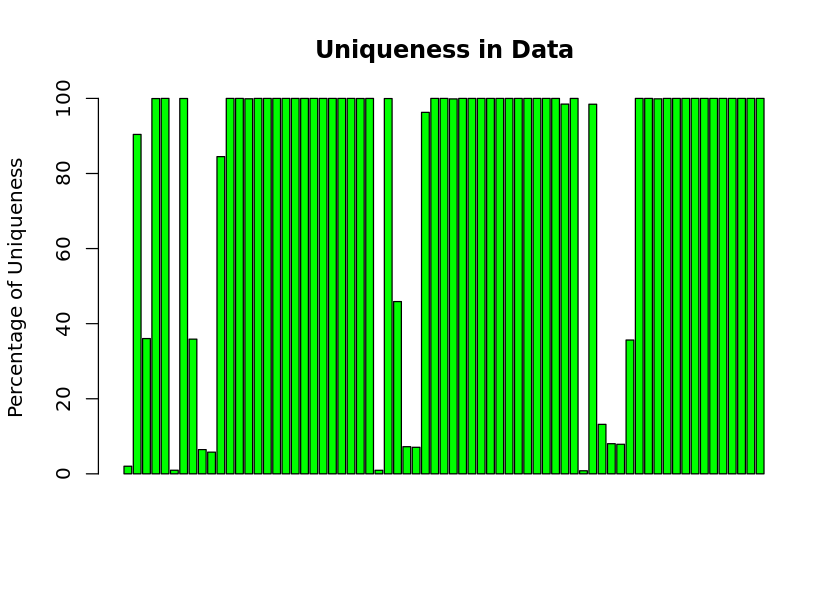

In [6]:
#create new dataframe without date
data.1 = data.frame(data[,2:ncol(data)])

#convert any NA's with mean values using imputeTS package
data.1 = na.mean(data.1)

#looking at data uniqueness
uniqueness = NULL
for(i in 1:ncol(data.1)){
  a = data.frame(percent = length(unique(data.1[,i]))/length(data.1[,i]))
  uniqueness = rbind.data.frame(uniqueness, a )
}

a = as.matrix(t(uniqueness))
options(repr.plot.width = 7, repr.plot.height = 5)
barplot(a*100, 
        main="Uniqueness in Data", 
        col=ifelse(a > 0.2,"red","green"),
        ylab="Percentage of Uniqueness")

In the above plot we can notice that most of the data we have is unique and that is good for analysis. Hence, we will see variance in the data.

In [7]:
uniques = data.frame(features = as.character(colnames(data.1)),
           unique = uniqueness)
uniqueFeatures = subset.data.frame(uniques,
                                   percent > 0.3)
#cols = as.character(uniqueFeatures$features)
uniqueFeatures.1 = subset(data.1, 
                          select = uniqueFeatures$features)

#### Box plots
Next, we need to look at data distributions. one way to do it is to use boxplots

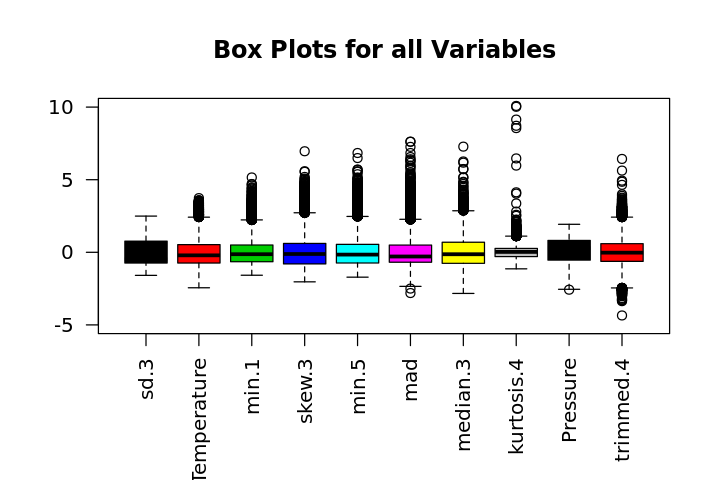

In [8]:
scale.data.1 = scale(uniqueFeatures.1)

options(repr.plot.width = 6, repr.plot.height = 4)

par(mar=c(6, 4, 4, 2) + 0.1)
boxplot(scale.data.1[,1:10], 
        main="Box Plots for all Variables", 
        col=1:ncol(data.1),
        las=2,
        ylim = c(-5,10))

### Machine state detection using GMM

#### Identify optimal number of clusters
We will identify optimal number of clusters in the data we have

Created from 23425 samples and 58 variables

Pre-processing:
  - ignored (0)
  - re-scaling to [0, 1] (58)



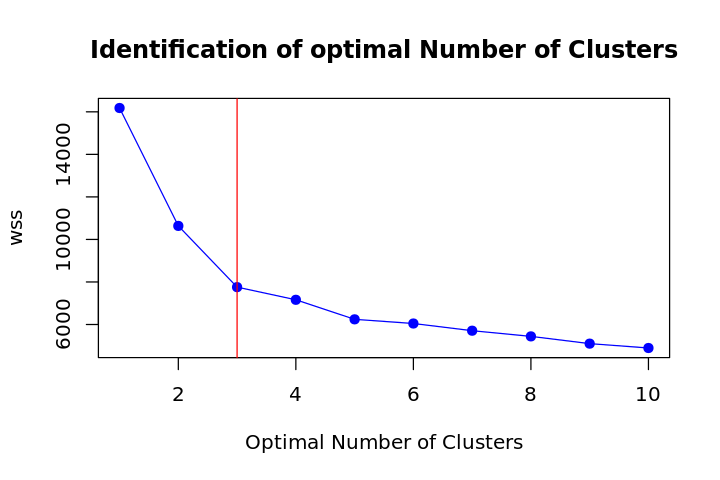

In [9]:
# calculate the pre-process parameters from the dataset
preprocessParams = preProcess(uniqueFeatures.1, method=c("range"))
# summarize transform parameters
print(preprocessParams)
# transform the dataset using the parameters
mydata = predict(preprocessParams, uniqueFeatures.1)

set.seed(1)
wss = (nrow(mydata) - 1) * sum(apply(mydata, 2, var))
for (j in 2:10) {
  set.seed(999)
  wss[j] = sum(kmeans(mydata,centers=j)$withinss)
}
plot(wss, 
     main="Identification of optimal Number of Clusters", 
     xlab="Optimal Number of Clusters",
     type="o",
     pch=19,
     col="blue") 
abline(v=3, col= "red")

#### Gaussian Mixture Model Clustering

Now we can fit GMM model to test the results. In the below graph we see the change of machine state quite frequently. Is the state when the machine turns on and off? Not sure. Should ask an expert about this

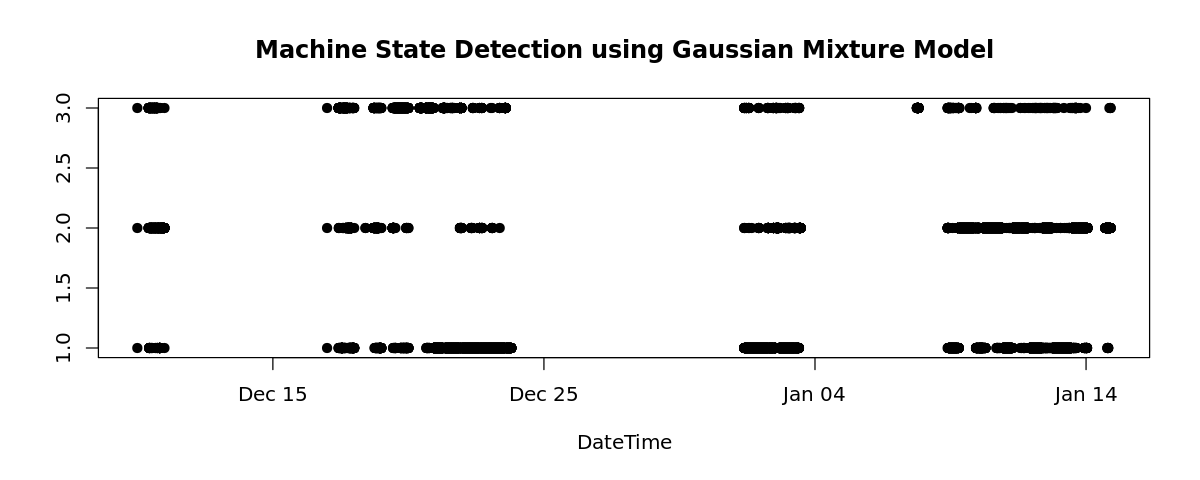

In [10]:
init = sample(1:nrow(mydata), size=1000)

m = densityMclust(mydata, 
                  3, 
                  verbose=F,
                  initialization=list(subset=init, set.seed(999))
                  )

#head(data$timeStamp)
#create dataframe with train and test results and date
GMM.result = data.frame(date =anytime(data$timeStamp), 
                        cluster = as.factor(m$classification),
                        occurance = 1
                        )

aggGMM.result = aggregate(GMM.result$occurance, 
                          list(GMM.result$date, GMM.result$cluster),
                          sum)
colnames(aggGMM.result) = c("date", "cluster", "occ")

GMM.result =aggGMM.result
#GMM.result = subset.data.frame(GMM.result, date >= Sys.Date()-1)
#write.table(GMM.result, "C:/Users/Gupta/Google Drive/sensehat 1/result.csv", sep=",", append=F, row.names=F)
options(repr.plot.width = 10, repr.plot.height = 4)
#plot the results
plot(
     GMM.result$date, 
     GMM.result$cluster, 
     type="p", 
    # col=GMM.result$y,
     #col = c("red","blue","green"),
     ylab="",
     main="Machine State Detection using Gaussian Mixture Model",
     xlab="DateTime",
     pch=19
     #yaxt="n"
     #cex = ifelse(aggGMM.result$occ >100,aggGMM.result$occ/500,1)
     )

#tail(GMM.result,100)

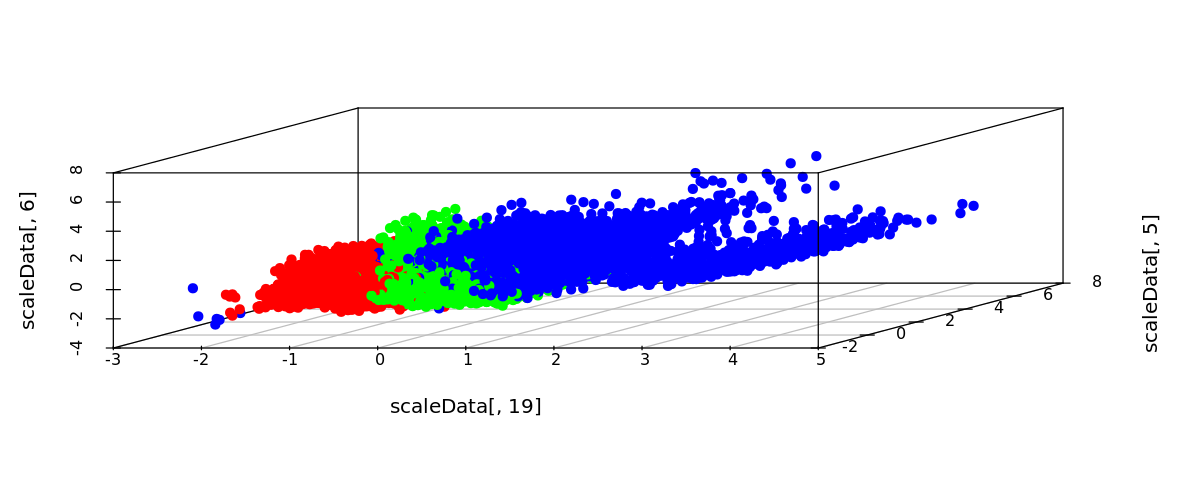

In [12]:
library(scatterplot3d)
scaleData = scale(mydata)
scatterplot3d( scaleData[,19],scaleData[,5],  scaleData[,6]   ,
              color=c("red","green", "blue") [m$classification], pch=19)